# Simulating Shor's Algorithm with Qiskit

This page is summarized of what I did at qiskit camp during Febrary 26th, 2019 to March 1st, 2019.

## 1. Qiskit
### 1.1 Real Device

<img src="QEC.gif" alt="drawing" width="400"/>

<img src="https://github.com/Qiskit/ibmq-device-information/raw/master/backends/yorktown/images/ibmqx2-labeled.png?raw=true" alt="ibmqx2_real" width="400"/>

<img src="https://github.com/Qiskit/ibmq-device-information/raw/master/backends/yorktown/images/ibmqx2_bus.png?raw=true" alt="ibmqx2_real" width="400"/>

Ref] https://github.com/Qiskit/ibmq-device-information/tree/master/backends/yorktown/V1

## 1.2 How to use

In [29]:
from qiskit import IBMQ

https://quantumexperience.ng.bluemix.net/qx/account/advanced

In [28]:
##If needed
#IBMQ.save_account('6f9fca906ff7204d585e92c0f91c5eaa8fad7751f8bab4a58757cf8f7b5d1dc1cc0f758daea7f116b48f1c6eeee0e85d1bc4c6845361389612e02f5e177d6eda')
IBMQ.load_accounts()

C:\Users\HaEum\Anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqprovider.py:251: UserWarning: Credentials are already in use.
  warnings.warn('Credentials are already in use.')


In [30]:
print("Available backends:")
##ibmq_16 : 13 qubits
##ibmqx2,ibmqx4 : 5 qubits 
IBMQ.backends()

Available backends:


[<IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmqx2') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ()>]

Make some easy quantum circuits and simulate with real device.

Single qubit operation :

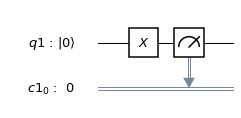

In [5]:
from qiskit import QuantumRegister,ClassicalRegister, QuantumCircuit

n = 1
q = QuantumRegister(n)
c = ClassicalRegister(n)
qc0 = QuantumCircuit(q,c)

qc0.x(q[0])
qc0.measure(q[0],c[0])

qc0.draw(output='mpl')

In [6]:
from qiskit.providers.ibmq import least_busy

large_enough_devices = IBMQ.backends(filters=lambda x: x.configuration().n_qubits > 4 and
                                                       not x.configuration().simulator)
backend = least_busy(large_enough_devices)
print("The best backend is " + backend.name())

The best backend is ibmqx4


In [7]:
from qiskit import execute
from qiskit.tools.monitor import job_monitor

shots = 100           # Number of shots to run the program (experiment); maximum is 8192 shots.
max_credits = 3        # Maximum number of credits to spend on executions. 

job_qc0 = execute(qc0,backend=backend,shots=shots, max_credits=max_credits)
job_monitor(job_qc0)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

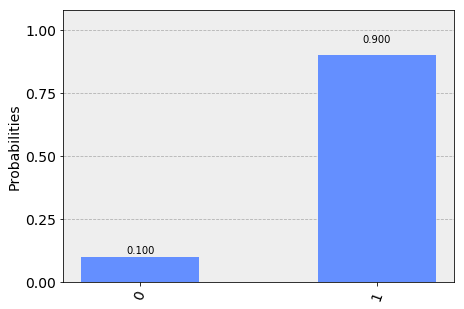

In [8]:
from qiskit.tools.visualization import plot_histogram

result_qc0 = job_qc0.result()
plot_histogram(result_qc0.get_counts())

Two qubit operation :

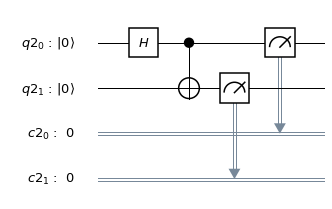

In [9]:
n = 2
q2 = QuantumRegister(n)
c2 = ClassicalRegister(n)
qc1 = QuantumCircuit(q2,c2)

qc1.h(q2[0])
qc1.cx(q2[0],q2[1])
qc1.measure(q2[0],c2[0])
qc1.measure(q2[1],c2[1])

qc1.draw(output='mpl')

In [20]:
shots = 100           # Number of shots to run the program (experiment); maximum is 8192 shots.
max_credits = 3        # Maximum number of credits to spend on executions. 

job_qc1 = execute(qc1,backend=backend,shots=shots, max_credits=max_credits)
job_monitor(job_qc1)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

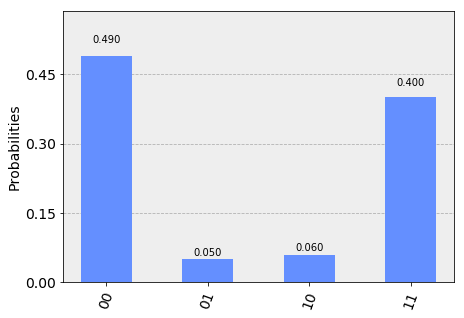

In [21]:
result_qc1 = job_qc1.result()
plot_histogram(result_qc1.get_counts())

We can check the result by simulating on our local classical computer :

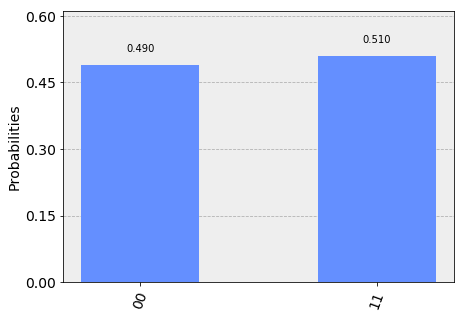

In [10]:
from qiskit import Aer

backend = Aer.get_backend("qasm_simulator")
simulate_qc1 = execute(qc1,backend=backend,shots=shots, max_credits=max_credits)

result_sim_qc1 = simulate_qc1.result()
plot_histogram(result_sim_qc1.get_counts())

# 2. Shor's Algorithm

## 2.1 Introduction

Shor's Algorithm is an algorithm for factorization that is efficient in quantum computer.

<img src="https://dal.objectstorage.open.softlayer.com/v1/AUTH_039c3bf6e6e54d76b8e66152e2f87877/images-classroom/shor-figure1l0qpbqeb138fr.png" alt="shor_vs_classical" width="800"/>

This result comes from factorizing an integer $N$ is similar to find period $r$

\begin{equation}
a^r\;(mod\;N)=1\;.
\end{equation}

With number theory, based on Chinese remainder theorem : 

Suppose $N$ is factorized with $m$ different odd prime numbers. Then $a$ and $r$ that satisfy the above equation,

\begin{equation}
Prob[(r\in Even)\cap\;(a^{r/2}(mod\;N)\neq-1)]\geq1-\frac{1}{2^m}
\end{equation}

Then with high probability

\begin{equation}
(a^{r/2}+1)(a^{r/2}-1)\;(mod\;N)=0\;,
\end{equation}

which means $GCD(a^{r/2}\pm1,N)$ are factors of $N$.



Ref] https://quantumexperience.ng.bluemix.net/proxy/tutorial/full-user-guide/004-Quantum_Algorithms/110-Shor%27s_algorithm.html

Ref] Nielsen, M. A., & Chuang, I. (2002). Quantum computation and quantum information.

## 2.2 The Reason why it is faster 

There are two reason that shor's algorithm is efficient at quantum computer than classical computer. The first reason is we can deal with all of candidate of period $r$ at one try with entangle state, and second reason is the efficiency of quantum fourier transform.

### 2.2.1 Order Finding Algorithm

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6b/Shor%27s_algorithm.svg/450px-Shor%27s_algorithm.svg.png" alt="shor_vs_classical" width="550"/>

\begin{equation}
\begin{aligned}
\vert 0 \rangle\vert 1 \rangle&\rightarrow
\frac{1}{\sqrt{2^t}}\sum^{2^t-1}_{j=0}\vert j \rangle\vert 1 \rangle\\
&\rightarrow
\frac{1}{\sqrt{2^t}}\sum^{2^t-1}_{j=0}\vert j \rangle\vert x^j\;(mod\;N) \rangle\\
&\;\;\;\;\approx\frac{1}{\sqrt{r2^t}}\sum^{r-1}_{s=0}\sum^{2^t-1}_{j=0}e^{2\pi isj/r}\vert j \rangle\vert u_s \rangle\\
&\rightarrow
\frac{1}{\sqrt{r}}\sum^{r-1}_{s=0}\vert \widetilde{s/r} \rangle\vert u_s \rangle\\
&\rightarrow
\widetilde{\frac{s}{r}}\;\;\;(s\in\{0,...,r-1\})
\end{aligned}
\end{equation}


### 2.2.2 Quantum Fourier Transform

Quantum Fourier Transform is exponential faster than classical algorithm because of the entanglement.

In [4]:
import math

def qft(circ,q,n):
    """n-qubit QFT on q in circ reverse order."""
    for j in range(n):
        for k in range(j):
            circ.cu1(math.pi/float(2**(j-k)), q[j], q[k])
        circ.h(q[j])
def inord(circ, q, n):
    """n-qubit ordering be correct to QFT"""
    for j in range(math.floor(n/2)):
        circ.swap(q[j],q[n-j-1])

example for 3 qubits fourier transform :

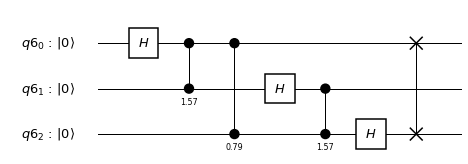

In [29]:
n=3
q=QuantumRegister(n)
qfc3=QuantumCircuit(q)
qft(qfc3,q,n)
inord(qfc3,q,n)
qfc3.draw(output='mpl')

\begin{equation}
\begin{aligned}
\vert j \rangle &\rightarrow \frac{1}{2^{n/2}}\sum^{2^n-1}_{k=0}e^{2\pi ijk/2^n}\vert k \rangle\\
&=\frac{(\vert 0 \rangle+e^{2\pi i0.j_n }\vert 1 \rangle)(\vert0 \rangle+e^{2\pi i0.j_{n-1}j_n}\vert1 \rangle)...(\vert0 \rangle+e^{2\pi i0.j_1 j_2 ...j_n }\vert1 \rangle)}{2^{n/2}}
\end{aligned}
\end{equation}

with 

\begin{equation}
j=j_1 2^{n-1}+j_2 2^{n-2}+...+j_n 2^{0}\\
\end{equation}

Simulatition with initial state $\vert \psi \rangle=  \frac{1}{\sqrt{8}}\sum^{7}_{k=0}\vert k \rangle$ :

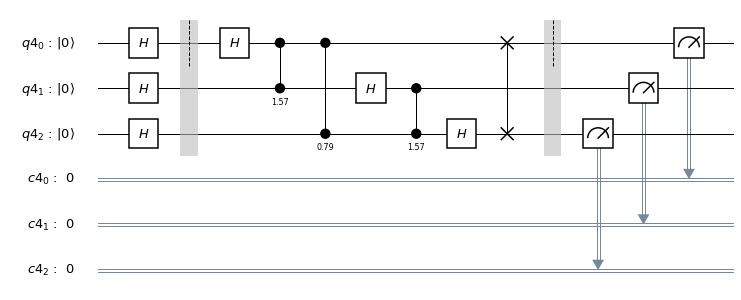

In [13]:
n=3
c=ClassicalRegister(n)
q=QuantumRegister(n)
qfc3=QuantumCircuit(q,c)

##input state
for i in range(n):
    qfc3.h(q[i])
qfc3.barrier()

##fourier transform
qft(qfc3,q,n)
inord(qfc3,q,n)

##measurment
qfc3.barrier()
for i in range(n):
    qfc3.measure(q[i], c[i])
qfc3.draw(output='mpl')

In [14]:
large_enough_devices = IBMQ.backends(filters=lambda x: x.configuration().n_qubits > 4 and
                                                       not x.configuration().simulator)
backend = least_busy(large_enough_devices)
print("The best backend is " + backend.name())

The best backend is ibmqx4


In [15]:
shots = 100           # Number of shots to run the program (experiment); maximum is 8192 shots.
max_credits = 3        # Maximum number of credits to spend on executions. 

job_qfc3 = execute(qfc3,backend=backend,shots=shots, max_credits=max_credits)
job_monitor(job_qfc3)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

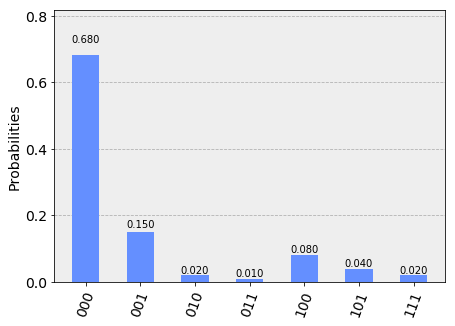

In [16]:
result_qfc3 = job_qfc3.result()
plot_histogram(result_qfc3.get_counts())

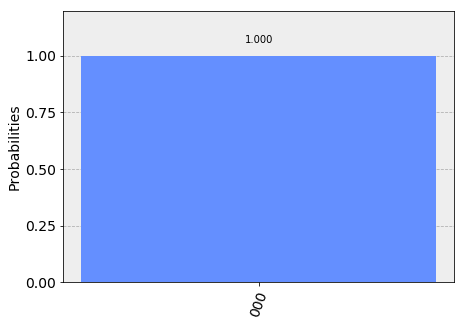

In [17]:
backend = Aer.get_backend("qasm_simulator")
simulate_qfc3 = execute(qfc3,backend=backend,shots=shots, max_credits=max_credits)

result_sim_qfc3 = simulate_qfc3.result()
plot_histogram(result_sim_qfc3.get_counts())

n = 4 :

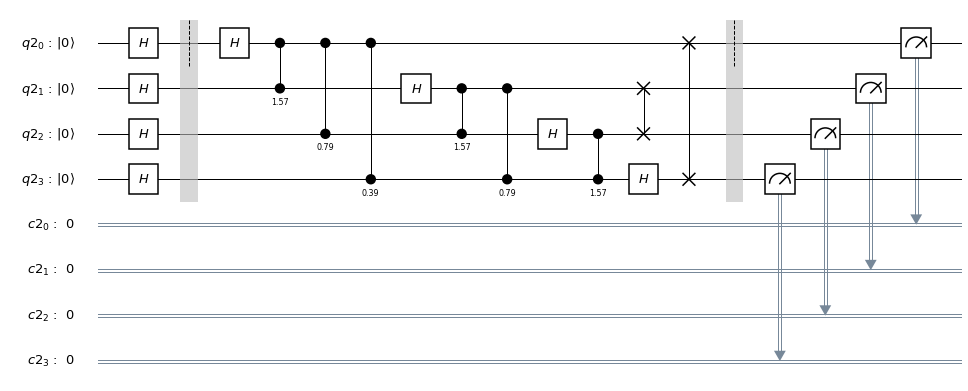

In [11]:
n=4
c=ClassicalRegister(n)
q=QuantumRegister(n)
qfc4=QuantumCircuit(q,c)

##input state
for i in range(n):
    qfc4.h(q[i])
qfc4.barrier()

##fourier transform
qft(qfc4,q,n)
inord(qfc4,q,n)

##measurment
qfc4.barrier()
for i in range(n):
    qfc4.measure(q[i], c[i])
qfc4.draw(output='mpl')

In [20]:
large_enough_devices = IBMQ.backends(filters=lambda x: x.configuration().n_qubits > 4 and
                                                       not x.configuration().simulator)
backend = least_busy(large_enough_devices)
print("The best backend is " + backend.name())

The best backend is ibmq_16_melbourne


In [17]:
shots = 1000           # Number of shots to run the program (experiment); maximum is 8192 shots.
max_credits = 3        # Maximum number of credits to spend on executions. 

job_qfc4 = execute(qfc4,backend=backend,shots=shots, max_credits=max_credits)
job_monitor(job_qfc4)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

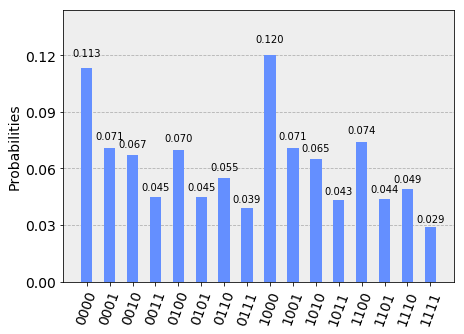

In [18]:
result_qfc4 = job_qfc4.result()
plot_histogram(result_qfc4.get_counts())

<img src="https://github.com/Qiskit/ibmq-device-information/raw/master/backends/yorktown/images/ibmqx2_bus.png?raw=true" alt="ibmqx2_real" width="400"/>

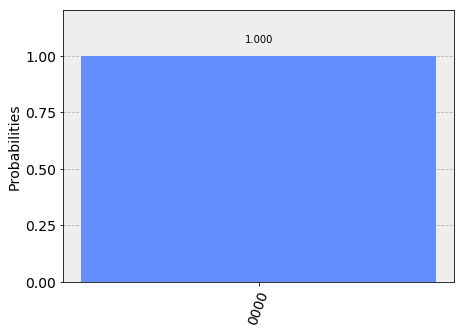

In [23]:
backend = Aer.get_backend("qasm_simulator")
simulate_qfc4 = execute(qfc4,backend=backend,shots=shots, max_credits=max_credits)

result_sim_qfc4 = simulate_qfc4.result()
plot_histogram(result_sim_qfc4.get_counts())

### 2.2.3 Controlled-Modulator

This operator works as

\begin{equation}
\vert 1 \rangle\rightarrow\vert a^x(mod\;N) \rangle\;.
\end{equation}

It is not as trivial to make in quantum circuit, and also has lot of way to construct it. But it can be constructed by polynomial cost. The below code is made by paper, V.Vedral, A.Barenco, A.Ekert,"Quantum networks for elementary arithmetic operations".

<img src="modular_exponentiation.png" alt="modular_exponentiation" width="600"/>

(  Ctrl-MULT-MOD : $\vert x_i \rangle\vert \beta \rangle\vert 0 \rangle\rightarrow\vert x_i \rangle\vert \beta \rangle\vert A\times \beta (mod\;N) \rangle$  )

In [2]:
import math
import numpy as np
from qiskit import QuantumRegister,ClassicalRegister,QuantumCircuit
from qiskit import Aer, execute
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram

In [25]:
# n-qubit number input state
def tobit(circuit, q, x, n):
    # integer to binary
    x = "{0:b}".format(x)
    #padleft
    x = x.zfill(n)
    # creating the state
    for i in range(n):
        if int(x[n-1-i]) == 1:
            circuit.x(q[i])
            
def cc_tobit(circuit, q, x, qc, qcx, n):
    # integer to binary
    x= "{0:b}".format(x)
    # padleft
    x = x.zfill(n)
    # creating the state
    # creating the state
    for i in range(n):
        if int(x[n-1-i]) == 1:
            circuit.ccx(qc[0], qcx, q[i])

def cc_tobit2(circuit, q, x, qc, qcx, n):
    # integer to binary
    x= "{0:b}".format(x)
    # padleft
    x = x.zfill(n)
    # creating the state
    # creating the state
    for i in range(n):
        if int(x[n-1-i]) == 1:
            circuit.ccx(qc, qcx, q[i])
            
            
def carry(circuit, q0, q1, q2, q3):
    circuit.ccx(q1, q2, q3)
    circuit.cx(q1, q2)
    circuit.ccx(q0, q2, q3)
    
def i_carry(circuit, q0, q1, q2, q3):
    circuit.ccx(q0, q2, q3)
    circuit.cx(q1, q2)
    circuit.ccx(q1, q2, q3)
    
def summing(circuit, q0, q1, q2):
    circuit.cx(q1, q2)
    circuit.cx(q0, q2)

def i_summing(circuit, q0, q1, q2):
    "summation module running backwards"
    circuit.cx(q0, q2)
    circuit.cx(q1, q2)
    
# quantum plain addition algorithm for n-qubit numbers    
def addition(circuit, qa, qb, qc, n):
    if n == 1:
        circuit.ccx(qa[0], qb[0], qb[1])
        circuit.cx(qa[0], qb[0])
    else:
        circuit.ccx(qa[0], qb[0], qc[0])
        circuit.cx(qa[0], qb[0])
        for i in range(n-2):
            carry(circuit, qc[i], qa[i+1], qb[i+1], qc[i+1])
        carry(circuit, qc[n-2], qa[n-1], qb[n-1], qb[n])
        circuit.cx(qa[n-1], qb[n-1])
        for i in range(n-1, 1, -1):
            summing(circuit, qc[i-1], qa[i], qb[i])
            i_carry(circuit, qc[i-2], qa[i-1], qb[i-1], qc[i-1])
        summing(circuit, qc[0], qa[1], qb[1])
        circuit.cx(qa[0], qb[0])
        circuit.ccx(qa[0], qb[0], qc[0])
        circuit.cx(qa[0], qb[0])

# Change to only reverse of original work
# quantum plain substraction algorithm for n-qubit numbers
def i_addition(circuit, qa, qb, qc, n):
    "same circuit as the plain addition but going backwards"
    if n == 1:
        circuit.cx(qa[0], qb[0])
        circuit.ccx(qa[0], qb[0], qb[1])
    else:
        circuit.cx(qa[0], qb[0])
        circuit.ccx(qa[0], qb[0], qc[0])
        circuit.cx(qa[0], qb[0])
        i_summing(circuit, qc[0], qa[1], qb[1])
        for i in range(2,n):
            carry(circuit, qc[i-2], qa[i-1], qb[i-1], qc[i-1])
            i_summing(circuit, qc[i-1], qa[i], qb[i])
        circuit.cx(qa[n-1], qb[n-1])
        i_carry(circuit, qc[n-2], qa[n-1], qb[n-1], qb[n])
        for i in range(n-3, -1, -1):
            i_carry(circuit, qc[i], qa[i+1], qb[i+1], qc[i+1])
        circuit.cx(qa[0], qb[0])  
        circuit.ccx(qa[0], qb[0], qc[0])
        
def judge(circuit, qN, qNtemp, qtemp, n):
    for i in range(n):
        circuit.ccx(qtemp[0],qNtemp[i],qN[i])

def judge2(circuit, qN, qNtemp, qtemp, n):
    for i in range(n):
        circuit.ccx(qtemp,qNtemp[i],qN[i])        
        
def addition_mod(circuit, qa, qb, qc, qN, qNtemp, qtemp, n):
    addition(circuit,qa,qb,qc,n)
    i_addition(circuit,qN,qb,qc,n)
    
    circuit.x(qb[n])
    circuit.cx(qb[n], qtemp[0])
    circuit.x(qb[n])
    
    judge(circuit, qN, qNtemp, qtemp, n)
    addition(circuit, qN, qb, qc, n)
    judge(circuit, qN, qNtemp, qtemp ,n)
    
    i_addition(circuit,qa,qb,qc,n)
    circuit.cx(qb[n], qtemp[0])
    addition(circuit,qa,qb,qc,n)
    
def i_addition_mod(circuit, qa, qb, qc, qN, qNtemp, qtemp, n):
    
    i_addition(circuit,qa,qb,qc,n)
    circuit.cx(qb[n], qtemp[0])
    addition(circuit,qa,qb,qc,n)
    
    judge(circuit, qN, qNtemp, qtemp, n)
    i_addition(circuit, qN, qb, qc, n)
    judge(circuit, qN, qNtemp, qtemp ,n)

    circuit.x(qb[n])
    circuit.cx(qb[n], qtemp[0])
    circuit.x(qb[n])

    addition(circuit,qN,qb,qc,n)
    i_addition(circuit,qa,qb,qc,n)
    
def c_multiple_mod(circuit, qmul, qx, qa, qb, qc, qN, qNadd, qadd, n, a, N):

    for j in range(n):
        tempa = (a*(2**j))%N
        cc_tobit2(circuit, qa, tempa , qmul, qx[j], n)
        addition_mod(circuit, qa, qb, qc, qN, qNadd, qadd, n)
        cc_tobit2(circuit, qa, tempa , qmul, qx[j], n)
    
    circuit.x(qmul)
    judge2(circuit, qb, qx, qmul, n)
    circuit.x(qmul)    
    
def c_i_multiple_mod(circuit, qmul, qx, qa, qb, qc, qN, qNadd, qadd, n, a, N):
    
    circuit.x(qmul)
    judge2(circuit, qb, qx, qmul, n)
    circuit.x(qmul)
 
    for j in range(n-1, -1, -1):
        tempa = (a*(2**j))%N
        cc_tobit2(circuit, qa, tempa , qmul, qx[j], n)
        i_addition_mod(circuit, qa, qb, qc, qN, qNadd, qadd, n)
        cc_tobit2(circuit, qa, tempa , qmul, qx[j], n)    

In [26]:
# efficient algorithm for computing the modular multiplicative inverse a^-1 mod m
def egcd(a,b): 
    bb = b
    u, u1 = 1, 0 
    v, v1 = 0, 1 
    while b: 
        q = a // b 
        u, u1 = u1, u - q * u1 
        v, v1 = v1, v - q * v1 
        a, b = b, a - q * b
    
    return u, v, a 

def modinv(a, m):
    u, v, g = egcd(a, m)
    if g != 1:
        raise Exception('modular inverse does not exist')
    else:
        return u % m

def exponentate_mod(circuit, qy, qx, qa, qb, qc, qN, qNadd, qadd, n, a, N, ny):    
    for j in range(ny) :
        aa = a**(2**j)%N
        c_multiple_mod(circuit, qy[j], qx, qa, qb, qc, qN, qNadd, qadd, n, aa, N)
        
        temp = qx
        qx = qb
        qb = temp
        
        i_aa = modinv(aa,N)
        c_i_multiple_mod(circuit, qy[j], qx, qa, qb, qc, qN, qNadd, qadd, n, i_aa, N)

Example for $x=3,a=5,N=7$,

\begin{equation}
\vert 3 \rangle\vert 1 \rangle\rightarrow\vert 3 \rangle\vert 5^3(mod\;7) \rangle= \vert3\rangle\vert 6 \rangle
\end{equation}

In [27]:
# we define the values
y = 3
a = 5              
N = 7

# computing number of qubits n needed
n = len("{0:b}".format(a))
n2 = len("{0:b}".format(N))
if n2 > n:
    n = n2
    
ny = len("{0:b}".format(y))

In [28]:
# classical register with n+1 bits.
cb = ClassicalRegister(n+1)
#ctemp=ClassicalRegister(1)

# quantum registers
qy = QuantumRegister(ny)
qx = QuantumRegister(n+1)
qa = QuantumRegister(n) # a qubits
qb = QuantumRegister(n+1) # b qubits
qc = QuantumRegister(n-1)
qN = QuantumRegister(n+1) # N qubits
qNadd = QuantumRegister(n+1) # temporary N qubits
qadd = QuantumRegister(1) # temporary qubit

modexpc = QuantumCircuit(qy, qx, qa, qb, qc, qN, qNadd, qadd, cb)

#On controller
#modexpc.x(qx[0])

#initial state
tobit(modexpc, qy, y, ny)
tobit(modexpc, qx, 1, n+1)
tobit(modexpc, qN, N, n+1)
tobit(modexpc, qNadd, N, n+1)

#c_multiple_mod
exponentate_mod(modexpc, qy, qx, qa, qb, qc, qN, qNadd, qadd, n, a, N, ny)

#qb always zero
#qx gives the result
for i in range(n+1):
    modexpc.measure(qx[i], cb[i])

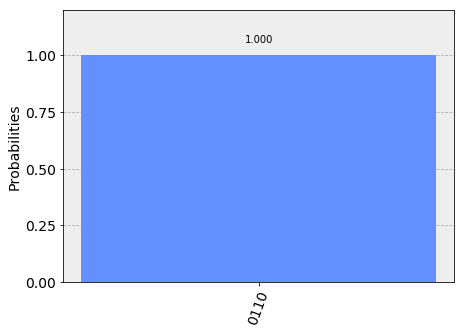

In [29]:
#choose backend as simulator
backend = Aer.get_backend('qasm_simulator')

# compile and execute the quantum program in the backend
job_exp = execute(modexpc, backend=backend, shots=1).result()

# show by histogram
counts = job_exp.get_counts(modexpc)
plot_histogram(counts)

## 2.3 Simulation

### 2.3.1 Quantum Computer

As quantum computer can't be runned with huge amount of qubits and operators, one of simulation we can do is finding order when $N=3$ and $a=2$.

\begin{equation}
2^r\;(mod\;3)=1\;.
\end{equation}

In [23]:
#inverse quantum fourier transform with 3 qubits
def i_qft(circ,q,n):
    """n-qubit QFT on q in circ reverse order."""
    for j in range(n-1,-1,-1):
        circ.h(q[j])
        for k in range(j-1,-1,-1):
            circ.cu1(math.pi/float(-2**(j-k)), q[j], q[k])

#hadamanrd gate sets
def had(circ,q):
    for i in range(3):
        circ.h(q[i])

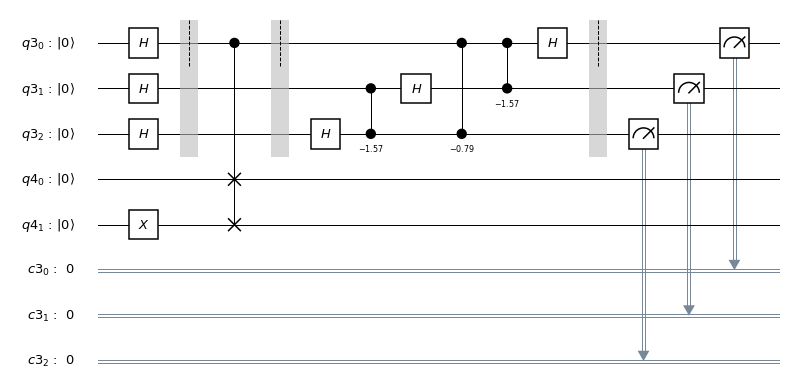

In [24]:

n=3
na=2
q=QuantumRegister(n)
a=QuantumRegister(na)
c=ClassicalRegister(n)
ofc=QuantumCircuit(q,a,c)

#initial state for modular qubit sets
ofc.x(a[1])

#entangled state
had(ofc,q)
ofc.barrier()

#controlled-modulator
ofc.cswap(q[0],a[0],a[1])
ofc.barrier()

#inverse fourier transform
i_qft(ofc,q,3)
ofc.barrier()

##measurment
for i in range(3):
    ofc.measure(q[i], c[i])
    
ofc.draw(output='mpl')

In [25]:
large_enough_devices = IBMQ.backends(filters=lambda x: x.configuration().n_qubits > 4 and
                                                       not x.configuration().simulator)
backend = least_busy(large_enough_devices)
print("The best backend is " + backend.name())

The best backend is ibmq_16_melbourne


In [26]:
shots = 1000            # Number of shots to run the program (experiment); maximum is 8192 shots.
max_credits = 3        # Maximum number of credits to spend on executions. 

job_ofc = execute(ofc,backend=backend,shots=shots, max_credits=max_credits)
job_monitor(job_ofc)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

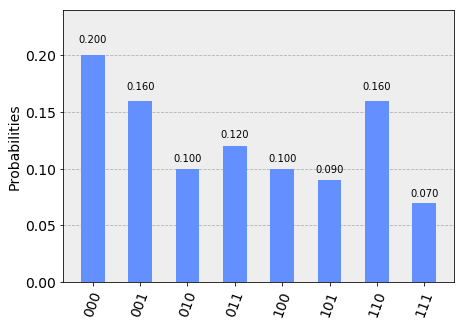

In [54]:
result_ofc = job_ofc.result()
plot_histogram(result_ofc.get_counts())

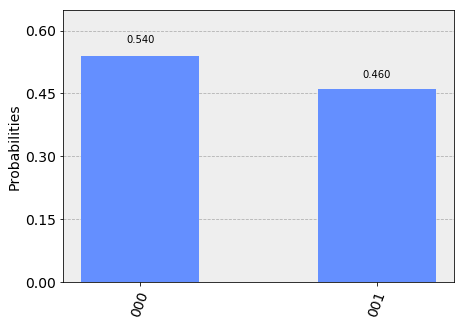

In [37]:
#choose backend as simulator
backend = Aer.get_backend('qasm_simulator')

# compile and execute the quantum program in the backend
sim_ofc = execute(ofc, backend=backend, shots=100).result()

# show by histogram
counts = sim_ofc.get_counts(ofc)
plot_histogram(counts)

As qubits means $0.q_1 q_2 q_3$, the result $\widetilde{s/r}$ is $0$ or $\frac{1}{2}$. So,

\begin{equation}
x^r(mod\;N)=2^2(mod\;3)=1.
\end{equation}

### 2.3.2 Local classical computer

The maximal size of qubits for $N$ can be used in qiskit is 3. Here, we give an example for $N=6$, $a=5$. 

In [47]:
# we define the values
ny = 3
a = 5              
N = 6

# computing number of qubits n needed
n = len("{0:b}".format(a))
n2 = len("{0:b}".format(N))
if n2 > n:
    n = n2

In [48]:
# classical register with n+1 bits.
cy = ClassicalRegister(ny)
#ctemp=ClassicalRegister(1)

# quantum registers
qy = QuantumRegister(ny)
qx = QuantumRegister(n+1)
qa = QuantumRegister(n) # a qubits
qb = QuantumRegister(n+1) # b qubits
qc = QuantumRegister(n-1)
qN = QuantumRegister(n+1) # N qubits
qNadd = QuantumRegister(n+1) # temporary N qubits
qadd = QuantumRegister(1) # temporary qubit

shor_circuit = QuantumCircuit(qy, qx, qa, qb, qc, qN, qNadd, qadd, cy)

#initial state
tobit(shor_circuit, qx, 1, n+1)
tobit(shor_circuit, qN, N, n+1)
tobit(shor_circuit, qNadd, N, n+1)

#hadamard gates for all qy qubits set 
for i in range(ny):
    shor_circuit.h(qy[i])    

#c_multiple_mod
exponentate_mod(shor_circuit, qy, qx, qa, qb, qc, qN, qNadd, qadd, n, a, N, ny)

#Fourier Transform
i_qft(shor_circuit,qy,ny)

#qx gives the result
for i in range(ny):
    shor_circuit.measure(qy[i], cy[i])

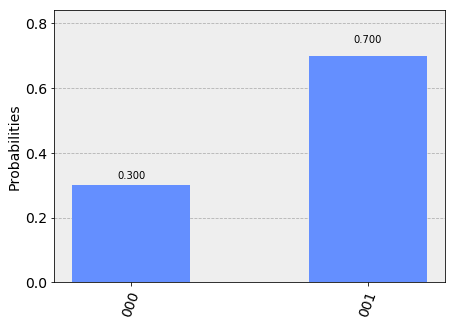

In [49]:
#choose backend as simulator
backend = Aer.get_backend('qasm_simulator')

# compile and execute the quantum program in the backend
job_add = execute(shor_circuit, backend=backend, shots=10).result()

# show by histogram
counts = job_add.get_counts(shor_circuit)
plot_histogram(counts)

As $r=2$, we can see one of factor of 6 is $GCD(5^{2/2}-1,6)=2$.